In [387]:
#QUESTIONS:
#batch normalization, gotta check what that is

#TODO:
#add regularization!
#more activations (tanh, softsign, leakyrelu relu6, elu, selu)
#break loop for convergence instead of running through all epochs?
# implement ROC curves!
#maybe confusion matrices?
#ADD PCA

In [62]:
#importing packages
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
import scipy.linalg as scl
import matplotlib.pyplot as plt

# define activation/deactivation functions

In [13]:
def sigmoid(s):
    return 1./(1.+np.exp(-s))
def sigmoid_backprop(da,x):
    sig = sigmoid(x)
    return da*sig*(1-sig)
def ReLU(s):
    return np.maximum(0,s) 
def ReLU_backprop(da,x):
    rel = ReLU(x)
    rel[rel>0]=1
    return da*rel

# create dictionaries for activation/deactivation functions (avoids if tests!)

In [3]:
activation_functions = {'sigmoid' :sigmoid, 'ReLU':ReLU}
deactivation_functions = {'sigmoid' : sigmoid_backprop, 'ReLU': ReLU_backprop}

# NN class

In [382]:
class binaryNN:
    def __init__(
            self,
            XTrain,
            yTrain,
            eta,
            nodes_per_layer,
            activation_per_layer,
            epochs = 10000,
            batch_size=100, #added
            seed=99
        ):
        self.XTrain = XTrain
        self.yTrain = yTrain.T
        self.seed   = seed
        # add final layer, 1 output node, using the sigmoid activation 
        # (so this NN only works for binary classification)
        nodes_per_layer.extend([1])
        activation_per_layer.extend(['sigmoid'])
        ###
        self.nodes_per_layer = nodes_per_layer
        self.activation_per_layer = activation_per_layer
        self.eta = eta
        self.epochs = epochs
        self.batch_size = batch_size #added
        self.iterations = self.XTrain.shape[0] // self.batch_size#added
        
    def initialize(
            self
        ):
        np.random.seed(self.seed)
        number_of_layers = len(self.activation_per_layer)
        self.nodes_per_layer = np.hstack((self.XTrain.shape[1],self.nodes_per_layer))
        self.parameter_values={}
        for idx in range(len(self.activation_per_layer)):
            layer_idx = idx+1
            layer_input_size = self.nodes_per_layer[idx]
            layer_output_size = self.nodes_per_layer[idx+1]
            np.random.seed(self.seed)
            ###############RANDOM#############
#             self.parameter_values['W'+str(layer_idx)] = np.random.randn(
#                                 layer_output_size,layer_input_size)*0.1
#             self.parameter_values['b'+str(layer_idx)] = np.random.randn(
#                                 layer_output_size,1)*0.1   
            
            ######FAIL XAVIER######################
#             xavier = np.sqrt(6)/np.sqrt(layer_output_size+layer_input_size)
#             self.parameter_values['W'+str(layer_idx)] = np.random.uniform(
#                                 -xavier,xavier,size=(layer_output_size,layer_input_size))
#             self.parameter_values['b'+str(layer_idx)] = 0

            ###########WORKING XAVIER##################
            stdd = np.sqrt(2/(layer_output_size+layer_input_size))
            self.parameter_values['W'+str(layer_idx)] = np.random.normal(
                                0.0,stdd,size=(layer_output_size,layer_input_size))
            self.parameter_values['b'+str(layer_idx)] = 0
         
    def forward_propagation(
        self,
        X
        ):
        self.layer_dict = {}
        self.a_current = X.T
        
        for idx in range(len(self.activation_per_layer)):
            layer_idx = idx+1
            self.a_previous = self.a_current
            self.W_current = self.parameter_values["W"+str(layer_idx)]
            self.b_current = self.parameter_values["b"+str(layer_idx)]
            self.z_current = self.W_current@self.a_previous+self.b_current
            self.a_current = activation_functions[self.activation_per_layer[idx]](self.z_current)
            self.layer_dict["a"+str(idx)] = self.a_previous
            self.layer_dict["z"+str(layer_idx)] = self.z_current

        return self.a_current
    
    def backward_propagation(
        self,
        y
        ):
        self.yBatch = y.T
        self.gradient_values={}
        m = self.a_previous.shape[1]
        da_previous = -(np.divide(self.yBatch,self.a_current)-np.divide(1-self.yBatch,1-self.a_current))

        for layer_idx_previous in reversed(range(len(self.activation_per_layer))):
            layer_idx_current = layer_idx_previous + 1
            da_current = da_previous

            a_previous = self.layer_dict["a" + str(layer_idx_previous)]
            z_current = self.layer_dict["z" + str(layer_idx_current)]
            W_current = self.parameter_values["W" + str(layer_idx_current)]
            b_current = self.parameter_values["b" + str(layer_idx_current)]

            n = a_previous.shape[1]
            dz_current = deactivation_functions[self.activation_per_layer[layer_idx_current-1]](da_current,z_current)
            dW_current = dz_current@a_previous.T/n
            db_current = np.sum(dz_current,axis=1,keepdims=True)/n
            da_previous = W_current.T@dz_current
            key_W = "dW" + str(layer_idx_current)
            key_b = "db" + str(layer_idx_current)
            
            self.gradient_values["dW" + str(layer_idx_current)] = dW_current
            self.gradient_values["db" + str(layer_idx_current)] = db_current 
            
    ### COST STUFF
    def cross_entropy(
        self,
        y_pred,
        y_real
        ):
        cost = (-1./y_pred.shape[1])*((y_real@(np.log(y_pred).T)+(1-y_real)@(np.log(1-y_pred)).T))
        return np.squeeze(cost[:,np.newaxis]) 
    
    def accuracy(
        self,
        y_pred,
        y_real
        ):
        if y_pred.shape[0] != 1:
            y_pred = y_pred.reshape(1,y_pred.shape[0])
        y_real = y_real.reshape(y_pred.shape)
        y_pred_classed = np.copy(y_pred)
        y_pred_classed[y_pred_classed>0.5]=1
        y_pred_classed[y_pred_classed<=0.5]=0
        return (y_pred_classed==y_real).all(axis=0).mean()
    
    ## UPDATE WEIGHTS AND BIASES
    def update(
        self
        ):
        for layer_idx in range(len(activation_per_layer)):
            layer_idx +=1
            self.parameter_values["W" + str(layer_idx)] -= self.eta * self.gradient_values["dW" + str(layer_idx)]        
            self.parameter_values["b" + str(layer_idx)] -= self.eta * self.gradient_values["db" + str(layer_idx)]
            
    def train(
        self
        ):
        self.initialize()
        self.cost_history = []
        self.accuracy_history = []
        data_indices = np.arange(self.XTrain.shape[0])
        
        for i in range(self.epochs):
            if i%1000==0:
                print("Calculating epoch ",i)
            for j in range(self.iterations):
                chosen_datapoints = np.random.choice(
                    data_indices,size=self.batch_size,replace=False)
                self.XData = self.XTrain[chosen_datapoints]
                self.yData = self.yTrain[chosen_datapoints]
                self.forward_propagation(self.XData)
                self.backward_propagation(self.yData)
                self.update()

            cost = self.cross_entropy(self.forward_propagation(self.XTrain),self.yTrain)
            self.cost_history.append(cost)
            accuracy = self.accuracy(self.forward_propagation(self.XTrain), self.yTrain)
            self.accuracy_history.append(accuracy)


# nn architecture

In [383]:
# nodes_per_layer = [100,50,70,80]
# activation_per_layer = ['sigmoid','ReLU','ReLU','ReLU']

nodes_per_layer = [100,50]
activation_per_layer = ['ReLU','ReLU'] #good on moons (96% accuracy), useless on cc(baseline accuracy).

# testing on skl moon data

In [384]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

from sklearn.datasets import make_moons
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [385]:
Moons = binaryNN(X_train_moons,y_train_moons,0.01,nodes_per_layer,activation_per_layer,epochs=10000)
Moons.train()

Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000
Calculating epoch  7000
Calculating epoch  8000
Calculating epoch  9000


Test set accuracy: 0.99 
Zero set accuracy: 0.54 


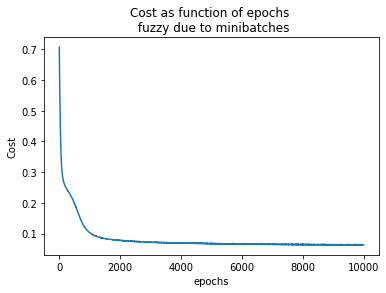

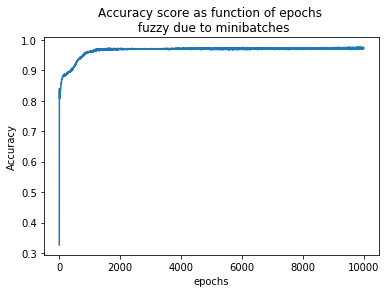

In [396]:
Y_test_hat_moons = Moons.forward_propagation(X_test_moons)
acc_test_moons = Moons.accuracy(Y_test_hat_moons, y_test_moons)
print("Test set accuracy: {:.2f} ".format(acc_test_moons))
zerot_moons = np.zeros(y_test_moons.shape[0])
acc_test_moons2 = Moons.accuracy(y_test_moons, zerot_moons)
print("Zero set accuracy: {:.2f} ".format(acc_test_moons2))

plt.figure()
plt.plot(Moons.cost_history)
plt.title("Cost as function of epochs \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Cost")
plt.show()


plt.figure()
plt.plot(Moons.accuracy_history)
plt.title("Accuracy score as function of epochs \n fuzzy due to minibatches")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000
Calculating epoch  7000
Calculating epoch  8000
Calculating epoch  9000


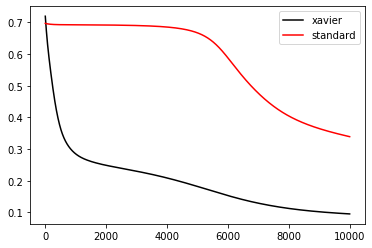

In [83]:
    ikke endre disse.
    #this is without minibatches
Moons2 = binaryNN(X_train_moons,y_train_moons,0.01,nodes_per_layer,activation_per_layer,epochs=10000)
Moons2.train()

plt.figure()
plt.plot(Moons.cost_history,'k',label='xavier')
plt.plot(Moons2.cost_history,'r',label='standard')
plt.legend()
plt.show()

# testing on credit card data

In [106]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                  test_size = 1-trainingShare,
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

In [107]:
#reading data
XTrain_cc,XTest_cc,yTrain_cc,yTest_cc = ReadData()

In [108]:
# train network
CreditCard = binaryNN(XTrain_cc,yTrain_cc,0.01,nodes_per_layer,activation_per_layer)
CreditCard.train()

Calculating epoch  0
Calculating epoch  1000
Calculating epoch  2000
Calculating epoch  3000
Calculating epoch  4000
Calculating epoch  5000
Calculating epoch  6000
Calculating epoch  7000
Calculating epoch  8000
Calculating epoch  9000


In [111]:
#find accuracy scores
Y_test_hat_cc = CreditCard.forward_propagation(XTest_cc)
# # Accuracy achieved on the test set
acc_test_cc = CreditCard.accuracy(Y_test_hat_cc, yTest_cc)
print("Test set accuracy: {:.2f} ".format(acc_test_cc))
zerot = np.zeros(yTest_cc.shape[0])
acc_test_cc2 = CreditCard.accuracy(np.transpose(yTest_cc.reshape((yTest_cc.shape[0], 1))), np.transpose(zerot.reshape((zerot.shape[0], 1))))

acc_test_cc2 = CreditCard.accuracy(yTest_cc,zerot)
print("Zero set accuracy: {:.2f} ".format(acc_test_cc2))

Test set accuracy: 0.78 
Zero set accuracy: 0.78 


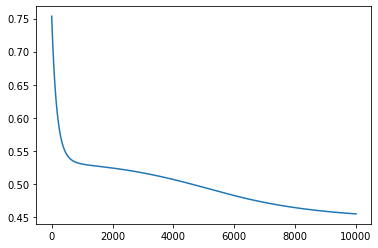

In [112]:
plt.plot(CreditCard.cost_history)

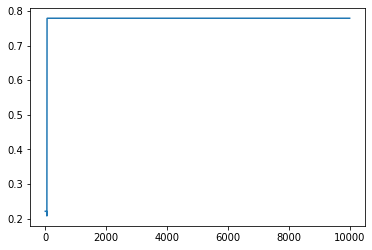

In [113]:
plt.plot((CreditCard.accuracy_history))